In [2]:
import os
import csv 
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import t

# ======================================================================
# Constants
# ======================================================================

YEAR = 2024
SIGMA = 5
"""
state_fips = {
    'AL': 1, 'AK': 2, 'AZ': 4, 'AR': 5, 'CA': 6,
    'CO': 8, 'CT': 9, 'DE': 10, 'FL': 12, 'GA': 13,
    'HI': 15, 'ID': 16, 'IL': 17, 'IN': 18, 'IA': 19,
    'KS': 20, 'KY': 21, 'LA': 22, 'ME': 23, 'MD': 24,
    'MA': 25, 'MI': 26, 'MN': 27, 'MS': 28, 'MO': 29,
    'MT': 30, 'NE': 31, 'NV': 32, 'NH': 33, 'NJ': 34,
    'NM': 35, 'NY': 36, 'NC': 37, 'ND': 38, 'OH': 39,
    'OK': 40, 'OR': 41, 'PA': 42, 'RI': 44, 'SC': 45,
    'SD': 46, 'TN': 47, 'TX': 48, 'UT': 49, 'VT': 50,
    'VA': 51, 'WA': 53, 'WV': 54, 'WI': 55, 'WY': 56,
    'DC': 11
}
"""

state_fips = {
    'MT': 30
}
# ======================================================================
# Helper Functions
# ======================================================================

def round_to_nearest_tens(x):
    return round(x / 10) * 10

# ======================================================================
# Meta-Margin Calculation 
# ======================================================================

# TODO: Implement

# ======================================================================
# Reading Shapefiles
# ======================================================================

df_all = pd.DataFrame()

for index, state_abbreviation in enumerate(state_fips):
    # Read shapefile information
    shape_file = gpd.read_file(f'../data/state_house_of_reps/district-shapes-{state_abbreviation}-sh/POLYGON.shp')
    shape_file['id'] = shape_file['id'].astype(int)
    shape_file = shape_file.rename(columns = {'id': 'NAMELSAD'})
    shape_file['NAMELSAD'] = shape_file['NAMELSAD'].apply(lambda x: f'Congressional District {x}')
    
    # Read election data & calculate margins
    csv_path = f'../data/state_house_of_reps/district-data-{state_abbreviation}-sh/district-data.csv'

    df = pd.read_csv(csv_path)
    df = df[['ID', 'E_20_PRES_Total', 'E_20_PRES_Dem', 'E_20_PRES_Rep']]
    df = df.drop(index=0)
    df['Margins'] = (df['E_20_PRES_Dem'] - df['E_20_PRES_Rep']) / df['E_20_PRES_Total']
    df = df.rename(columns = {'ID': 'NAMELSAD'})
    
    # Voter Power Calculation
    # t-pdf setup 
    deg_f = 3 
    t_dist = t(deg_f)

    # For sanity checking
    # TODO: Ask about how meta margin changes for different elections... 
    metamargin = 0 

    Z = (df['Margins'] - metamargin) / SIGMA
    num = t_dist.pdf(Z)
    den = df['E_20_PRES_Total']

    df['Voter Power'] = np.divide(num, den)

    # Renaming variables and adding STATEFP
    df['NAMELSAD'] = df['NAMELSAD'].apply(lambda x: f'Congressional District {x}')
    df["STATEFP"] = state_fips[state_abbreviation]

    # Merging data
    df = pd.merge(df, shape_file[['NAMELSAD', 'geometry']], on = 'NAMELSAD')
    
    if index == 0:
        df_all = pd.concat([df_all, df[['NAMELSAD', 'Margins', 'STATEFP', 'Voter Power', 'geometry']]], ignore_index=True)
    else: 
        df_all = pd.concat([df_all[['NAMELSAD', 'Margins', 'STATEFP', 'Voter Power', 'geometry']], df[['NAMELSAD', 'Margins', 'STATEFP', 'Voter Power', 'geometry']]], axis=0)
        
    print(df_all.head())
    
# Normalize Voter Power
df_all['Voter Power'] = ((df_all['Voter Power']  - df_all['Voter Power'].min()) / (df_all['Voter Power'].max() - df_all['Voter Power'].min()))*100
df_all['Voter Power'] = df_all['Voter Power'].apply(round_to_nearest_tens)
print(df_all)

# Save Data 
dir_path = os.path.dirname(os.path.realpath("__file__"))
path = os.path.join(dir_path, f'../outputs/{YEAR}.stateHouse.VoterPower.csv')
df_all.to_csv(path, index=False, float_format='%.2f')

                   NAMELSAD   Margins  STATEFP  Voter Power  \
0  Congressional District 1 -0.507958       30     0.000054   
1  Congressional District 2 -0.507705       30     0.000059   
2  Congressional District 3  0.081995       30     0.000052   
3  Congressional District 4 -0.042767       30     0.000060   
4  Congressional District 5 -0.451129       30     0.000058   

                                            geometry  
0  POLYGON ((-116.04903 48.51533, -116.04907 48.4...  
1  POLYGON ((-114.84856 48.35902, -114.84857 48.3...  
2  POLYGON ((-114.43903 48.35635, -114.43902 48.3...  
3  POLYGON ((-114.18388 48.36188, -114.18193 48.3...  
4  POLYGON ((-114.20977 48.35717, -114.21152 48.3...  
                      NAMELSAD   Margins  STATEFP  Voter Power  \
0     Congressional District 1 -0.507958       30           10   
1     Congressional District 2 -0.507705       30           20   
2     Congressional District 3  0.081995       30           10   
3     Congressional Distric

<Axes: >

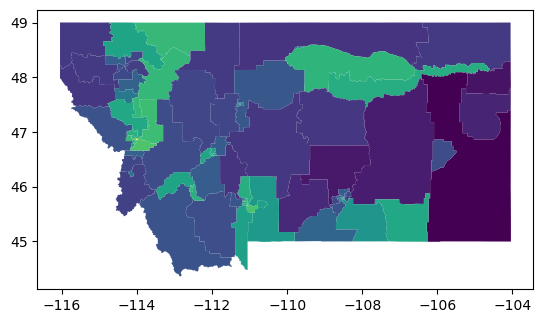

In [4]:
csv_path = f'../outputs/{YEAR}.stateHouse.VoterPower.csv'
df = pd.read_csv(csv_path)

from shapely import wkt
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs='epsg:4326')
gdf.plot("Margins")